# Session 6 Assignment on Regularization and Normalization

This is an incomplete Submission, without the GBN implementation and identification of the misclassified images. Only the following combinations are implemented and the corresponding chart is created

1. without L1/L2 with BN --> This model is already underfitting and hence the expected improvements from the below techniques should be lower. It has a training accuracy of 99.19% and Validation accuracy of 99.40%  
2. without L1/L2 with GBN --> Not Completed     
3. with L1 with BN --> This model decreases the training accuracy to 98.91% and the validation accuracy to 99.29%. The validation accuracy has been oscillating at around 99.30% time for multiple epochs.       
4. with L1 with GBN --> Not Completed        
5. with L2 with BN --> This reaches a training accuracy of 99.25% along with a validation accuracy of 99.50% by the 25th epoch making it the best performing model         
6. with L2 with GBN --> Not completed       
7. with L1 and L2 with BN --> This has the lowest accuracy of all models. Probably because its over regualrized        
8. with L1 and L2 with GBN --> Not completed       


In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
import pandas as pd

In [0]:
class GhostBatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features * self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features * self.num_splits))

    def train(self, mode=True):
        if (self.training is True) and (mode is False):  # lazily collate stats when we are going to use them
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
        return super().train(mode)

    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            return F.batch_norm(
                input.view(-1, C * self.num_splits, H, W), self.running_mean, self.running_var,
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W)
        else:
            return F.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features],
                self.weight, self.bias, False, self.momentum, self.eps)


In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, padding=0)     #(k=3,p=0,s=1) input = 28, output = 26, rf = 3, jump = 1
        self.batchnorm1 = nn.BatchNorm2d(8)
        self.dropout1 = nn.Dropout(0.10)
        self.conv2 = nn.Conv2d(8, 8, 3, padding=0)     #(k=3,p=0,s=1) input = 26, output = 24, rf = 5, jump = 1
        self.batchnorm2 = nn.BatchNorm2d(8)
        self.dropout2 = nn.Dropout(0.10)
        self.conv3 = nn.Conv2d(8, 8, 3, padding=0)     #(k=3,p=0,s=1) input = 24, output = 22, rf = 7, jump = 1
        self.batchnorm3 = nn.BatchNorm2d(8)
        self.dropout3 = nn.Dropout(0.10)
        self.pool1 = nn.AvgPool2d(2, 2)                #(k=2,p=0,s=2) input = 22, output = 11, rf = 8, jump = 1
        self.conv4 = nn.Conv2d(8, 16, 3, padding=0)    #(k=3,p=0,s=1) input = 11, output = 9, rf = 12, jump = 2
        self.batchnorm4 = nn.BatchNorm2d(16)
        self.dropout4 = nn.Dropout(0.10)
        self.conv5 = nn.Conv2d(16, 16, 3, padding=0)   #(k=3,p=0,s=1) input = 9, output = 7, rf = 16, jump = 2
        self.batchnorm5 = nn.BatchNorm2d(16)
        self.dropout5 = nn.Dropout(0.10)
        self.conv6 = nn.Conv2d(16, 32, 3, padding=0)   #(k=3,p=0,s=1) input = 7, output = 5, rf = 20, jump = 2
        self.batchnorm6 = nn.BatchNorm2d(32)
        self.dropout6 = nn.Dropout(0.10)
        self.pool2 = nn.AvgPool2d(5, 5)                #(k=5,p=0,s=5) input = 5, output = 1, rf = 28, jump = 2
        self.conv8 = nn.Conv2d(32, 10, 1)


    def forward(self, x):
        x = self.pool1(self.dropout3(self.batchnorm3(F.relu(self.conv3(self.dropout2(self.batchnorm2(F.relu(self.conv2(self.dropout1(self.batchnorm1(F.relu(self.conv1(x)))))))))))))
        x = self.pool2(self.dropout6(self.batchnorm6(F.relu(self.conv6(self.dropout5(self.batchnorm5(F.relu(self.conv5(self.dropout4(self.batchnorm4(F.relu(self.conv4(x)))))))))))))
        x = self.conv8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x)

In [0]:
class NetGBN(nn.Module):
    def __init__(self):
        super(NetGBN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, padding=0)     #(k=3,p=0,s=1) input = 28, output = 26, rf = 3, jump = 1
        self.batchnorm1 = GhostBatchNorm(8,8)
        self.dropout1 = nn.Dropout(0.10)
        self.conv2 = nn.Conv2d(8, 8, 3, padding=0)     #(k=3,p=0,s=1) input = 26, output = 24, rf = 5, jump = 1
        self.batchnorm2 = GhostBatchNorm(8,8)
        self.dropout2 = nn.Dropout(0.10)
        self.conv3 = nn.Conv2d(8, 8, 3, padding=0)     #(k=3,p=0,s=1) input = 24, output = 22, rf = 7, jump = 1
        self.batchnorm3 = GhostBatchNorm(8,8)
        self.dropout3 = nn.Dropout(0.10)
        self.pool1 = nn.AvgPool2d(2, 2)                #(k=2,p=0,s=2) input = 22, output = 11, rf = 8, jump = 1
        self.conv4 = nn.Conv2d(8, 16, 3, padding=0)    #(k=3,p=0,s=1) input = 11, output = 9, rf = 12, jump = 2
        self.batchnorm4 = GhostBatchNorm(16,8)
        self.dropout4 = nn.Dropout(0.10)
        self.conv5 = nn.Conv2d(16, 16, 3, padding=0)   #(k=3,p=0,s=1) input = 9, output = 7, rf = 16, jump = 2
        self.batchnorm5 = GhostBatchNorm(16,8)
        self.dropout5 = nn.Dropout(0.10)
        self.conv6 = nn.Conv2d(16, 32, 3, padding=0)   #(k=3,p=0,s=1) input = 7, output = 5, rf = 20, jump = 2
        self.batchnorm6 = GhostBatchNorm(32,8)
        self.dropout6 = nn.Dropout(0.10)
        self.pool2 = nn.AvgPool2d(5, 5)                #(k=5,p=0,s=5) input = 5, output = 1, rf = 28, jump = 2
        self.conv8 = nn.Conv2d(32, 10, 1)


    def forward(self, x):
        x = self.pool1(self.dropout3(self.batchnorm3(F.relu(self.conv3(self.dropout2(self.batchnorm2(F.relu(self.conv2(self.dropout1(self.batchnorm1(F.relu(self.conv1(x)))))))))))))
        x = self.pool2(self.dropout6(self.batchnorm6(F.relu(self.conv6(self.dropout5(self.batchnorm5(F.relu(self.conv5(self.dropout4(self.batchnorm4(F.relu(self.conv4(x)))))))))))))
        x = self.conv8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x)

In [5]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
modelGBN = NetGBN().to(device)
summary(model, input_size=(1, 28, 28))
#summary(modelGBN, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
       BatchNorm2d-2            [-1, 8, 26, 26]              16
           Dropout-3            [-1, 8, 26, 26]               0
            Conv2d-4            [-1, 8, 24, 24]             584
       BatchNorm2d-5            [-1, 8, 24, 24]              16
           Dropout-6            [-1, 8, 24, 24]               0
            Conv2d-7            [-1, 8, 22, 22]             584
       BatchNorm2d-8            [-1, 8, 22, 22]              16
           Dropout-9            [-1, 8, 22, 22]               0
        AvgPool2d-10            [-1, 8, 11, 11]               0
           Conv2d-11             [-1, 16, 9, 9]           1,168
      BatchNorm2d-12             [-1, 16, 9, 9]              32
          Dropout-13             [-1, 16, 9, 9]               0
           Conv2d-14             [-1, 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [6]:
torch.manual_seed(1)
batch_size =64

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.RandomRotation((-5.0,5.0),fill=(1,)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [7]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch=0, L1 = 0):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        reg_loss = 0
        for param in model.parameters():
          reg_loss += torch.sum(torch.abs(param))
        loss += L1 * reg_loss
        loss.backward()
        optimizer.step()
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

    print('\nTrain set: Accuracy: {}/{} ({:.2f}%)\n'.format(
        correct, len(train_loader.dataset),
        100. * correct / len(train_loader.dataset)))


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return test_loss, (100. * correct / len(test_loader.dataset))

In [0]:
#Parameter list has list of parameters, each list has four parameters
#1st parameter is the name of the combination
#2nd parameter is l1 regularization
#3rd parameter is l2 regualization
#4th parameter is Batch Normalization required or not
#5th parameter is Ghost Batch Normalization is required or not

L1 = 0.0001
NO_L1 = 0.0
L2 = 0.0001
NO_L2 = 0.0

parameter_list = [["NO_L1L2_with_BN",NO_L1,NO_L2,"BN"],["L1_with_BN",L1,NO_L2,"BN"],["L2_with_BN",NO_L1,L2,"BN"],["L1L2_with_BN",L1,L2,"BN"]]
df_loss = pd.DataFrame()
df_accuracy = pd.DataFrame()
i = 0

In [9]:
for parameter in parameter_list:
  Name = parameter[0]  
  L1 = parameter[1]
  L2 = parameter[2]
  BN_GBN = parameter[3]
  model = Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=L2)
  scheduler = StepLR(optimizer,step_size=2,gamma=0.2)
  test_loss_list = []
  test_accuracy_list = []
  for epoch in range(1, 26):
      print("\n",Name," EPOC NUMBER IS :", epoch)
      train(model, device, train_loader, optimizer, epoch = epoch,L1 = L1)
      test_loss, test_accuracy = test(model, device, test_loader)
      test_loss_list.append(test_loss)
      test_accuracy_list.append(test_accuracy)
      print("\n--------------------------------------------------------------------------- \n")
  df_loss.insert(i,Name,test_loss_list)
  df_accuracy.insert(i,Name,test_accuracy_list)
  i += 1
  torch.save(model.state_dict(),Name)

  0%|          | 0/938 [00:00<?, ?it/s]


 NO_L1L2_with_BN  EPOC NUMBER IS : 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
loss=0.1990373730659485 batch_id=937: 100%|██████████| 938/938 [00:22<00:00, 40.87it/s]


Train set: Accuracy: 55621/60000 (92.70%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0514, Accuracy: 9845/10000 (98.45%)


--------------------------------------------------------------------------- 


 NO_L1L2_with_BN  EPOC NUMBER IS : 2


loss=0.032700300216674805 batch_id=937: 100%|██████████| 938/938 [00:21<00:00, 43.29it/s]


Train set: Accuracy: 58618/60000 (97.70%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0430, Accuracy: 9867/10000 (98.67%)


--------------------------------------------------------------------------- 


 NO_L1L2_with_BN  EPOC NUMBER IS : 3


loss=0.026548676192760468 batch_id=937: 100%|██████████| 938/938 [00:21<00:00, 43.32it/s]


Train set: Accuracy: 58906/60000 (98.18%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0316, Accuracy: 9901/10000 (99.01%)


--------------------------------------------------------------------------- 


 NO_L1L2_with_BN  EPOC NUMBER IS : 4


loss=0.06755894422531128 batch_id=937: 100%|██████████| 938/938 [00:21<00:00, 43.59it/s]


Train set: Accuracy: 59060/60000 (98.43%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0259, Accuracy: 9923/10000 (99.23%)


--------------------------------------------------------------------------- 


 NO_L1L2_with_BN  EPOC NUMBER IS : 5


loss=0.020113766193389893 batch_id=937: 100%|██████████| 938/938 [00:21<00:00, 44.60it/s]


Train set: Accuracy: 59143/60000 (98.57%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Accuracy: 9927/10000 (99.27%)


--------------------------------------------------------------------------- 


 NO_L1L2_with_BN  EPOC NUMBER IS : 6


loss=0.0069802552461624146 batch_id=937: 100%|██████████| 938/938 [00:20<00:00, 45.84it/s]


Train set: Accuracy: 59207/60000 (98.68%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9930/10000 (99.30%)


--------------------------------------------------------------------------- 


 NO_L1L2_with_BN  EPOC NUMBER IS : 7


loss=0.0027318596839904785 batch_id=937: 100%|██████████| 938/938 [00:20<00:00, 45.98it/s]


Train set: Accuracy: 59270/60000 (98.78%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9935/10000 (99.35%)


--------------------------------------------------------------------------- 


 NO_L1L2_with_BN  EPOC NUMBER IS : 8


loss=0.0013560652732849121 batch_id=937: 100%|██████████| 938/938 [00:20<00:00, 44.85it/s]


Train set: Accuracy: 59331/60000 (98.89%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9927/10000 (99.27%)


--------------------------------------------------------------------------- 


 NO_L1L2_with_BN  EPOC NUMBER IS : 9


loss=0.007559001445770264 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 46.91it/s]


Train set: Accuracy: 59286/60000 (98.81%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9940/10000 (99.40%)


--------------------------------------------------------------------------- 


 NO_L1L2_with_BN  EPOC NUMBER IS : 10


loss=0.1355908215045929 batch_id=937: 100%|██████████| 938/938 [00:20<00:00, 46.02it/s]


Train set: Accuracy: 59371/60000 (98.95%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9933/10000 (99.33%)


--------------------------------------------------------------------------- 


 NO_L1L2_with_BN  EPOC NUMBER IS : 11


loss=0.0028320252895355225 batch_id=937: 100%|██████████| 938/938 [00:20<00:00, 46.87it/s]


Train set: Accuracy: 59360/60000 (98.93%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9931/10000 (99.31%)


--------------------------------------------------------------------------- 


 NO_L1L2_with_BN  EPOC NUMBER IS : 12


loss=0.040729820728302 batch_id=937: 100%|██████████| 938/938 [00:20<00:00, 46.54it/s]


Train set: Accuracy: 59402/60000 (99.00%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9939/10000 (99.39%)


--------------------------------------------------------------------------- 


 NO_L1L2_with_BN  EPOC NUMBER IS : 13


loss=0.008897647261619568 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 47.37it/s]


Train set: Accuracy: 59411/60000 (99.02%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9939/10000 (99.39%)


--------------------------------------------------------------------------- 


 NO_L1L2_with_BN  EPOC NUMBER IS : 14


loss=0.002820730209350586 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 47.36it/s]


Train set: Accuracy: 59408/60000 (99.01%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9934/10000 (99.34%)


--------------------------------------------------------------------------- 


 NO_L1L2_with_BN  EPOC NUMBER IS : 15


loss=0.023603364825248718 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 47.16it/s]


Train set: Accuracy: 59400/60000 (99.00%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9943/10000 (99.43%)


--------------------------------------------------------------------------- 


 NO_L1L2_with_BN  EPOC NUMBER IS : 16


loss=0.0007844269275665283 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 47.56it/s]


Train set: Accuracy: 59440/60000 (99.07%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9942/10000 (99.42%)


--------------------------------------------------------------------------- 


 NO_L1L2_with_BN  EPOC NUMBER IS : 17


loss=0.10392329096794128 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 47.84it/s]


Train set: Accuracy: 59450/60000 (99.08%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9942/10000 (99.42%)


--------------------------------------------------------------------------- 


 NO_L1L2_with_BN  EPOC NUMBER IS : 18


loss=0.006899058818817139 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 48.42it/s]


Train set: Accuracy: 59445/60000 (99.08%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9947/10000 (99.47%)


--------------------------------------------------------------------------- 


 NO_L1L2_with_BN  EPOC NUMBER IS : 19


loss=0.0029706954956054688 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 47.49it/s]


Train set: Accuracy: 59468/60000 (99.11%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9945/10000 (99.45%)


--------------------------------------------------------------------------- 


 NO_L1L2_with_BN  EPOC NUMBER IS : 20


loss=0.01611711084842682 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 47.95it/s]


Train set: Accuracy: 59470/60000 (99.12%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9941/10000 (99.41%)


--------------------------------------------------------------------------- 


 NO_L1L2_with_BN  EPOC NUMBER IS : 21


loss=0.026206031441688538 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 47.43it/s]


Train set: Accuracy: 59472/60000 (99.12%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 9941/10000 (99.41%)


--------------------------------------------------------------------------- 


 NO_L1L2_with_BN  EPOC NUMBER IS : 22


loss=0.03953206539154053 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 47.57it/s]


Train set: Accuracy: 59531/60000 (99.22%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9940/10000 (99.40%)


--------------------------------------------------------------------------- 


 NO_L1L2_with_BN  EPOC NUMBER IS : 23


loss=0.17156487703323364 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 47.92it/s]


Train set: Accuracy: 59496/60000 (99.16%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9947/10000 (99.47%)


--------------------------------------------------------------------------- 


 NO_L1L2_with_BN  EPOC NUMBER IS : 24


loss=0.004524946212768555 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 48.39it/s]


Train set: Accuracy: 59491/60000 (99.15%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9943/10000 (99.43%)


--------------------------------------------------------------------------- 


 NO_L1L2_with_BN  EPOC NUMBER IS : 25


loss=0.006629526615142822 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 47.49it/s]


Train set: Accuracy: 59513/60000 (99.19%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9940/10000 (99.40%)


--------------------------------------------------------------------------- 


 L1_with_BN  EPOC NUMBER IS : 1


loss=0.21578480303287506 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 46.99it/s]


Train set: Accuracy: 56042/60000 (93.40%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0462, Accuracy: 9859/10000 (98.59%)


--------------------------------------------------------------------------- 


 L1_with_BN  EPOC NUMBER IS : 2


loss=0.17376941442489624 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 48.05it/s]


Train set: Accuracy: 58745/60000 (97.91%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0341, Accuracy: 9895/10000 (98.95%)


--------------------------------------------------------------------------- 


 L1_with_BN  EPOC NUMBER IS : 3


loss=0.14133620262145996 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 47.20it/s]


Train set: Accuracy: 58922/60000 (98.20%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0319, Accuracy: 9900/10000 (99.00%)


--------------------------------------------------------------------------- 


 L1_with_BN  EPOC NUMBER IS : 4


loss=0.08005127310752869 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 47.88it/s]


Train set: Accuracy: 59027/60000 (98.38%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0295, Accuracy: 9918/10000 (99.18%)


--------------------------------------------------------------------------- 


 L1_with_BN  EPOC NUMBER IS : 5


loss=0.11685203015804291 batch_id=937: 100%|██████████| 938/938 [00:20<00:00, 46.75it/s]


Train set: Accuracy: 59075/60000 (98.46%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0289, Accuracy: 9914/10000 (99.14%)


--------------------------------------------------------------------------- 


 L1_with_BN  EPOC NUMBER IS : 6


loss=0.09192708134651184 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 47.11it/s]


Train set: Accuracy: 59112/60000 (98.52%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0265, Accuracy: 9919/10000 (99.19%)


--------------------------------------------------------------------------- 


 L1_with_BN  EPOC NUMBER IS : 7


loss=0.1862991750240326 batch_id=937: 100%|██████████| 938/938 [00:20<00:00, 46.46it/s]


Train set: Accuracy: 59151/60000 (98.58%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0283, Accuracy: 9916/10000 (99.16%)


--------------------------------------------------------------------------- 


 L1_with_BN  EPOC NUMBER IS : 8


loss=0.06444744765758514 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 48.62it/s]


Train set: Accuracy: 59191/60000 (98.65%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9921/10000 (99.21%)


--------------------------------------------------------------------------- 


 L1_with_BN  EPOC NUMBER IS : 9


loss=0.23036912083625793 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 47.85it/s]


Train set: Accuracy: 59198/60000 (98.66%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Accuracy: 9920/10000 (99.20%)


--------------------------------------------------------------------------- 


 L1_with_BN  EPOC NUMBER IS : 10


loss=0.08629035949707031 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 48.30it/s]


Train set: Accuracy: 59186/60000 (98.64%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Accuracy: 9923/10000 (99.23%)


--------------------------------------------------------------------------- 


 L1_with_BN  EPOC NUMBER IS : 11


loss=0.11679281294345856 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 47.96it/s]


Train set: Accuracy: 59236/60000 (98.73%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9927/10000 (99.27%)


--------------------------------------------------------------------------- 


 L1_with_BN  EPOC NUMBER IS : 12


loss=0.15562310814857483 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 47.33it/s]


Train set: Accuracy: 59241/60000 (98.73%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9938/10000 (99.38%)


--------------------------------------------------------------------------- 


 L1_with_BN  EPOC NUMBER IS : 13


loss=0.0780734121799469 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 48.30it/s]


Train set: Accuracy: 59311/60000 (98.85%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9934/10000 (99.34%)


--------------------------------------------------------------------------- 


 L1_with_BN  EPOC NUMBER IS : 14


loss=0.12266723811626434 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 49.04it/s]


Train set: Accuracy: 59283/60000 (98.81%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0257, Accuracy: 9914/10000 (99.14%)


--------------------------------------------------------------------------- 


 L1_with_BN  EPOC NUMBER IS : 15


loss=0.07663261890411377 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 48.88it/s]


Train set: Accuracy: 59342/60000 (98.90%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0273, Accuracy: 9921/10000 (99.21%)


--------------------------------------------------------------------------- 


 L1_with_BN  EPOC NUMBER IS : 16


loss=0.07685352861881256 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 47.44it/s]


Train set: Accuracy: 59331/60000 (98.89%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 9914/10000 (99.14%)


--------------------------------------------------------------------------- 


 L1_with_BN  EPOC NUMBER IS : 17


loss=0.06311279535293579 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 48.05it/s]


Train set: Accuracy: 59297/60000 (98.83%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0241, Accuracy: 9934/10000 (99.34%)


--------------------------------------------------------------------------- 


 L1_with_BN  EPOC NUMBER IS : 18


loss=0.07057107239961624 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 48.63it/s]


Train set: Accuracy: 59303/60000 (98.84%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9933/10000 (99.33%)


--------------------------------------------------------------------------- 


 L1_with_BN  EPOC NUMBER IS : 19


loss=0.20769566297531128 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 48.23it/s]


Train set: Accuracy: 59273/60000 (98.79%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9932/10000 (99.32%)


--------------------------------------------------------------------------- 


 L1_with_BN  EPOC NUMBER IS : 20


loss=0.06421207636594772 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 47.98it/s]


Train set: Accuracy: 59318/60000 (98.86%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9933/10000 (99.33%)


--------------------------------------------------------------------------- 


 L1_with_BN  EPOC NUMBER IS : 21


loss=0.06798042356967926 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 48.40it/s]


Train set: Accuracy: 59316/60000 (98.86%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9925/10000 (99.25%)


--------------------------------------------------------------------------- 


 L1_with_BN  EPOC NUMBER IS : 22


loss=0.14538654685020447 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 48.50it/s]


Train set: Accuracy: 59346/60000 (98.91%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9932/10000 (99.32%)


--------------------------------------------------------------------------- 


 L1_with_BN  EPOC NUMBER IS : 23


loss=0.11907382309436798 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 48.01it/s]



Train set: Accuracy: 59343/60000 (98.91%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9927/10000 (99.27%)


--------------------------------------------------------------------------- 


 L1_with_BN  EPOC NUMBER IS : 24


loss=0.08356557786464691 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 47.49it/s]


Train set: Accuracy: 59290/60000 (98.82%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9936/10000 (99.36%)


--------------------------------------------------------------------------- 


 L1_with_BN  EPOC NUMBER IS : 25


loss=0.06026964262127876 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 47.88it/s]


Train set: Accuracy: 59344/60000 (98.91%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9929/10000 (99.29%)


--------------------------------------------------------------------------- 


 L2_with_BN  EPOC NUMBER IS : 1


loss=0.016823291778564453 batch_id=937: 100%|██████████| 938/938 [00:20<00:00, 46.86it/s]


Train set: Accuracy: 55684/60000 (92.81%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0554, Accuracy: 9849/10000 (98.49%)


--------------------------------------------------------------------------- 


 L2_with_BN  EPOC NUMBER IS : 2


loss=0.09071621298789978 batch_id=937: 100%|██████████| 938/938 [00:20<00:00, 46.79it/s]


Train set: Accuracy: 58749/60000 (97.92%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0345, Accuracy: 9903/10000 (99.03%)


--------------------------------------------------------------------------- 


 L2_with_BN  EPOC NUMBER IS : 3


loss=0.012684613466262817 batch_id=937: 100%|██████████| 938/938 [00:20<00:00, 46.50it/s]


Train set: Accuracy: 58959/60000 (98.27%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0276, Accuracy: 9910/10000 (99.10%)


--------------------------------------------------------------------------- 


 L2_with_BN  EPOC NUMBER IS : 4


loss=0.0158860981464386 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 47.00it/s]


Train set: Accuracy: 59119/60000 (98.53%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0307, Accuracy: 9903/10000 (99.03%)


--------------------------------------------------------------------------- 


 L2_with_BN  EPOC NUMBER IS : 5


loss=0.05275043845176697 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 47.04it/s]


Train set: Accuracy: 59174/60000 (98.62%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9934/10000 (99.34%)


--------------------------------------------------------------------------- 


 L2_with_BN  EPOC NUMBER IS : 6


loss=0.05535263568162918 batch_id=937: 100%|██████████| 938/938 [00:20<00:00, 46.35it/s]


Train set: Accuracy: 59226/60000 (98.71%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9932/10000 (99.32%)


--------------------------------------------------------------------------- 


 L2_with_BN  EPOC NUMBER IS : 7


loss=0.004465639591217041 batch_id=937: 100%|██████████| 938/938 [00:20<00:00, 46.33it/s]


Train set: Accuracy: 59301/60000 (98.83%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9934/10000 (99.34%)


--------------------------------------------------------------------------- 


 L2_with_BN  EPOC NUMBER IS : 8


loss=0.008284032344818115 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 47.14it/s]


Train set: Accuracy: 59297/60000 (98.83%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9928/10000 (99.28%)


--------------------------------------------------------------------------- 


 L2_with_BN  EPOC NUMBER IS : 9


loss=0.28886640071868896 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 47.39it/s]


Train set: Accuracy: 59352/60000 (98.92%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9935/10000 (99.35%)


--------------------------------------------------------------------------- 


 L2_with_BN  EPOC NUMBER IS : 10


loss=0.01070760190486908 batch_id=937: 100%|██████████| 938/938 [00:20<00:00, 46.82it/s]


Train set: Accuracy: 59336/60000 (98.89%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9943/10000 (99.43%)


--------------------------------------------------------------------------- 


 L2_with_BN  EPOC NUMBER IS : 11


loss=0.017442479729652405 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 46.98it/s]


Train set: Accuracy: 59370/60000 (98.95%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9935/10000 (99.35%)


--------------------------------------------------------------------------- 


 L2_with_BN  EPOC NUMBER IS : 12


loss=0.010936588048934937 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 47.53it/s]


Train set: Accuracy: 59394/60000 (98.99%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9938/10000 (99.38%)


--------------------------------------------------------------------------- 


 L2_with_BN  EPOC NUMBER IS : 13


loss=0.11165715008974075 batch_id=937: 100%|██████████| 938/938 [00:20<00:00, 46.77it/s]


Train set: Accuracy: 59367/60000 (98.94%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9944/10000 (99.44%)


--------------------------------------------------------------------------- 


 L2_with_BN  EPOC NUMBER IS : 14


loss=0.04897156357765198 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 47.17it/s]


Train set: Accuracy: 59405/60000 (99.01%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9932/10000 (99.32%)


--------------------------------------------------------------------------- 


 L2_with_BN  EPOC NUMBER IS : 15


loss=0.07485675811767578 batch_id=937: 100%|██████████| 938/938 [00:20<00:00, 46.90it/s]


Train set: Accuracy: 59424/60000 (99.04%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0162, Accuracy: 9949/10000 (99.49%)


--------------------------------------------------------------------------- 


 L2_with_BN  EPOC NUMBER IS : 16


loss=0.09120756387710571 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 47.78it/s]


Train set: Accuracy: 59434/60000 (99.06%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0152, Accuracy: 9958/10000 (99.58%)


--------------------------------------------------------------------------- 


 L2_with_BN  EPOC NUMBER IS : 17


loss=0.007243677973747253 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 47.81it/s]


Train set: Accuracy: 59438/60000 (99.06%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9947/10000 (99.47%)


--------------------------------------------------------------------------- 


 L2_with_BN  EPOC NUMBER IS : 18


loss=0.021327659487724304 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 47.81it/s]


Train set: Accuracy: 59475/60000 (99.12%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9938/10000 (99.38%)


--------------------------------------------------------------------------- 


 L2_with_BN  EPOC NUMBER IS : 19


loss=0.0031765401363372803 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 47.55it/s]


Train set: Accuracy: 59459/60000 (99.10%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0171, Accuracy: 9947/10000 (99.47%)


--------------------------------------------------------------------------- 


 L2_with_BN  EPOC NUMBER IS : 20


loss=0.013715207576751709 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 47.48it/s]


Train set: Accuracy: 59480/60000 (99.13%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Accuracy: 9944/10000 (99.44%)


--------------------------------------------------------------------------- 


 L2_with_BN  EPOC NUMBER IS : 21


loss=0.010831013321876526 batch_id=937: 100%|██████████| 938/938 [00:20<00:00, 46.50it/s]


Train set: Accuracy: 59507/60000 (99.18%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0158, Accuracy: 9948/10000 (99.48%)


--------------------------------------------------------------------------- 


 L2_with_BN  EPOC NUMBER IS : 22


loss=0.009000793099403381 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 47.55it/s]


Train set: Accuracy: 59478/60000 (99.13%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9944/10000 (99.44%)


--------------------------------------------------------------------------- 


 L2_with_BN  EPOC NUMBER IS : 23


loss=0.13300469517707825 batch_id=937: 100%|██████████| 938/938 [00:20<00:00, 46.77it/s]


Train set: Accuracy: 59509/60000 (99.18%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0167, Accuracy: 9950/10000 (99.50%)


--------------------------------------------------------------------------- 


 L2_with_BN  EPOC NUMBER IS : 24


loss=0.033768974244594574 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 47.63it/s]


Train set: Accuracy: 59496/60000 (99.16%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0158, Accuracy: 9945/10000 (99.45%)


--------------------------------------------------------------------------- 


 L2_with_BN  EPOC NUMBER IS : 25


loss=0.09292373061180115 batch_id=937: 100%|██████████| 938/938 [00:20<00:00, 46.69it/s]


Train set: Accuracy: 59551/60000 (99.25%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0158, Accuracy: 9950/10000 (99.50%)


--------------------------------------------------------------------------- 


 L1L2_with_BN  EPOC NUMBER IS : 1


loss=0.2375028282403946 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 48.18it/s]


Train set: Accuracy: 55913/60000 (93.19%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0498, Accuracy: 9847/10000 (98.47%)


--------------------------------------------------------------------------- 


 L1L2_with_BN  EPOC NUMBER IS : 2


loss=0.06956461071968079 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 47.53it/s]


Train set: Accuracy: 58759/60000 (97.93%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0371, Accuracy: 9886/10000 (98.86%)


--------------------------------------------------------------------------- 


 L1L2_with_BN  EPOC NUMBER IS : 3


loss=0.07470916956663132 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 47.53it/s]


Train set: Accuracy: 58901/60000 (98.17%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0344, Accuracy: 9895/10000 (98.95%)


--------------------------------------------------------------------------- 


 L1L2_with_BN  EPOC NUMBER IS : 4


loss=0.06512685865163803 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 47.73it/s]


Train set: Accuracy: 59035/60000 (98.39%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0256, Accuracy: 9924/10000 (99.24%)


--------------------------------------------------------------------------- 


 L1L2_with_BN  EPOC NUMBER IS : 5


loss=0.0735815018415451 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 48.42it/s]


Train set: Accuracy: 59076/60000 (98.46%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0303, Accuracy: 9910/10000 (99.10%)


--------------------------------------------------------------------------- 


 L1L2_with_BN  EPOC NUMBER IS : 6


loss=0.06254013627767563 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 47.37it/s]


Train set: Accuracy: 59155/60000 (98.59%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0273, Accuracy: 9912/10000 (99.12%)


--------------------------------------------------------------------------- 


 L1L2_with_BN  EPOC NUMBER IS : 7


loss=0.07641725242137909 batch_id=937: 100%|██████████| 938/938 [00:20<00:00, 45.49it/s]


Train set: Accuracy: 59143/60000 (98.57%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0272, Accuracy: 9919/10000 (99.19%)


--------------------------------------------------------------------------- 


 L1L2_with_BN  EPOC NUMBER IS : 8


loss=0.21531891822814941 batch_id=937: 100%|██████████| 938/938 [00:20<00:00, 46.62it/s]


Train set: Accuracy: 59201/60000 (98.67%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0279, Accuracy: 9915/10000 (99.15%)


--------------------------------------------------------------------------- 


 L1L2_with_BN  EPOC NUMBER IS : 9


loss=0.08118326961994171 batch_id=937: 100%|██████████| 938/938 [00:20<00:00, 46.88it/s]


Train set: Accuracy: 59180/60000 (98.63%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Accuracy: 9904/10000 (99.04%)


--------------------------------------------------------------------------- 


 L1L2_with_BN  EPOC NUMBER IS : 10


loss=0.059412822127342224 batch_id=937: 100%|██████████| 938/938 [00:20<00:00, 46.48it/s]


Train set: Accuracy: 59225/60000 (98.71%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Accuracy: 9929/10000 (99.29%)


--------------------------------------------------------------------------- 


 L1L2_with_BN  EPOC NUMBER IS : 11


loss=0.17528685927391052 batch_id=937: 100%|██████████| 938/938 [00:20<00:00, 46.32it/s]


Train set: Accuracy: 59150/60000 (98.58%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9923/10000 (99.23%)


--------------------------------------------------------------------------- 


 L1L2_with_BN  EPOC NUMBER IS : 12


loss=0.1332666575908661 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 47.73it/s]


Train set: Accuracy: 59249/60000 (98.75%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0241, Accuracy: 9926/10000 (99.26%)


--------------------------------------------------------------------------- 


 L1L2_with_BN  EPOC NUMBER IS : 13


loss=0.1602507084608078 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 47.76it/s]


Train set: Accuracy: 59245/60000 (98.74%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0244, Accuracy: 9923/10000 (99.23%)


--------------------------------------------------------------------------- 


 L1L2_with_BN  EPOC NUMBER IS : 14


loss=0.10059595108032227 batch_id=937: 100%|██████████| 938/938 [00:20<00:00, 46.47it/s]


Train set: Accuracy: 59254/60000 (98.76%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9927/10000 (99.27%)


--------------------------------------------------------------------------- 


 L1L2_with_BN  EPOC NUMBER IS : 15


loss=0.15367957949638367 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 47.42it/s]


Train set: Accuracy: 59249/60000 (98.75%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0273, Accuracy: 9918/10000 (99.18%)


--------------------------------------------------------------------------- 


 L1L2_with_BN  EPOC NUMBER IS : 16


loss=0.10048962384462357 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 47.55it/s]


Train set: Accuracy: 59215/60000 (98.69%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0269, Accuracy: 9914/10000 (99.14%)


--------------------------------------------------------------------------- 


 L1L2_with_BN  EPOC NUMBER IS : 17


loss=0.05784880369901657 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 48.21it/s]


Train set: Accuracy: 59240/60000 (98.73%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9929/10000 (99.29%)


--------------------------------------------------------------------------- 


 L1L2_with_BN  EPOC NUMBER IS : 18


loss=0.08195434510707855 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 47.52it/s]


Train set: Accuracy: 59271/60000 (98.78%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0295, Accuracy: 9909/10000 (99.09%)


--------------------------------------------------------------------------- 


 L1L2_with_BN  EPOC NUMBER IS : 19


loss=0.11171495914459229 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 47.12it/s]


Train set: Accuracy: 59284/60000 (98.81%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9920/10000 (99.20%)


--------------------------------------------------------------------------- 


 L1L2_with_BN  EPOC NUMBER IS : 20


loss=0.05877411738038063 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 48.54it/s]


Train set: Accuracy: 59254/60000 (98.76%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9916/10000 (99.16%)


--------------------------------------------------------------------------- 


 L1L2_with_BN  EPOC NUMBER IS : 21


loss=0.12640562653541565 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 47.67it/s]


Train set: Accuracy: 59324/60000 (98.87%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9929/10000 (99.29%)


--------------------------------------------------------------------------- 


 L1L2_with_BN  EPOC NUMBER IS : 22


loss=0.33357658982276917 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 47.14it/s]


Train set: Accuracy: 59276/60000 (98.79%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0260, Accuracy: 9925/10000 (99.25%)


--------------------------------------------------------------------------- 


 L1L2_with_BN  EPOC NUMBER IS : 23


loss=0.06796525418758392 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 47.80it/s]


Train set: Accuracy: 59302/60000 (98.84%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Accuracy: 9920/10000 (99.20%)


--------------------------------------------------------------------------- 


 L1L2_with_BN  EPOC NUMBER IS : 24


loss=0.07655760645866394 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 47.82it/s]


Train set: Accuracy: 59280/60000 (98.80%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9935/10000 (99.35%)


--------------------------------------------------------------------------- 


 L1L2_with_BN  EPOC NUMBER IS : 25


loss=0.13172967731952667 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 47.09it/s]


Train set: Accuracy: 59333/60000 (98.89%)




Test set: Average loss: 0.0235, Accuracy: 9926/10000 (99.26%)


--------------------------------------------------------------------------- 



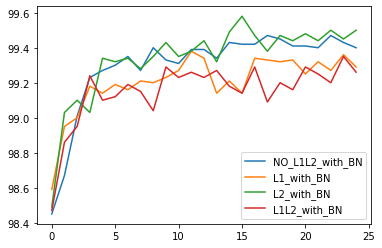

In [10]:
df_accuracy.plot.line()

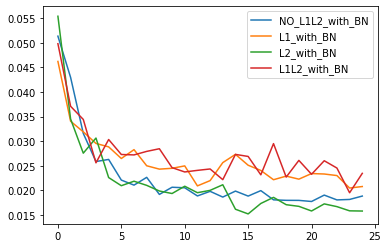

In [11]:
df_loss.plot.line()